<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/SparseRenderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import jax.numpy as jnp
#import numpy as np
from jax import jit, vmap
import jax
from jax.experimental import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm

In [116]:
!pip install mediapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import mediapy as media

In [128]:
key = jax.random.PRNGKey(110)
p_count = 1024 * 256 # 2048 # 1024*1024 # 1024*1024*40
positions = jax.random.normal(key, (p_count,2))
#positions = positions

In [3]:
def draw_points_dense(pos, psize=4):
  canvas = jnp.ones((256, 256, 3))
  for point in pos:
    img_p = (point * 20 + 128).astype("uint16")
    canvas = canvas.at[img_p[0] : img_p[0] + psize, img_p[1] : img_p[1] + psize].set(0)
  return canvas

In [4]:
# too slow with 1M points!
# plt.imshow(draw_points_dense(positions))

In [5]:
def draw_single_point(pos, dims, psize):
  data = jnp.ones(psize * psize)
  xr = jnp.arange(psize) + pos[0]
  yr = jnp.arange(psize) + pos[1]
  indices = jnp.dstack(jnp.meshgrid(xr, yr)).reshape(psize * psize, 2).astype(jnp.int16)
  return sparse.BCOO((data, indices), shape=dims)

In [6]:
def draw_points(all_pos, canv_dims, psize=4):
  draw_bound = lambda p: draw_single_point(p, canv_dims, psize)
  draw_all = vmap(draw_bound)
  render = draw_all(all_pos).sum(0)
  return sparse.todense(render) # render

In [7]:
draw_jit = jit(draw_points, static_argnums=(1, 2))

In [8]:
# too memory inefficient for >2M points!
#%%timeit
#draw_points(positions * 40 + 128, (256,256), 4)

In [9]:
#plt.imshow(sparse.todense(draw_points(positions * 40 + 128, (256,256), 4)))

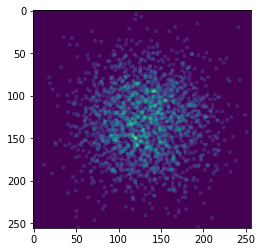

In [10]:
plt.imshow(draw_jit(positions * 40 + 128, (256, 256), 4))

In [11]:
# this will actually run faster when the image is larger and the points are more spread out,
# because there will be less overlapping writes! 
%%timeit
draw_jit(positions * 128 + 512, (1024,1024), 4)

The slowest run took 890.58 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 450 µs per loop


In [12]:
draw_jit(positions * 128 + 512, (1024,1024), 4).shape

(1024, 1024)

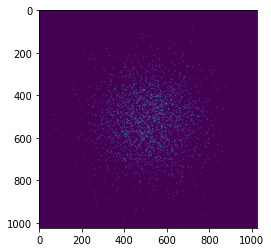

In [13]:
plt.imshow(draw_jit(positions * 128 + 512, (1024,1024), 4))

### Generate test sprite sheet of gaussians of various sizes

In [42]:
def gaussian_kern(kernlen, nsig):
    """Returns a 2D Gaussian kernel."""

    x = jnp.linspace(-nsig, nsig, kernlen+1)
    kern1d = jnp.diff(jax.scipy.stats.norm.cdf(x))
    kern2d = jnp.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [119]:
num_sprites = 16
sprite_dim = 31
gauss_sprites = jnp.stack([gaussian_kern(sprite_dim, i) for i in range(3, 3 + num_sprites)]) 

In [120]:
gauss_sprites.shape

(16, 31, 31)

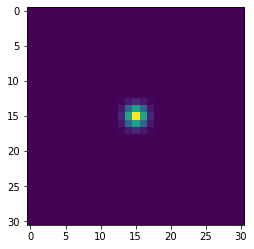

In [86]:
plt.imshow(gauss_sprites[14])

In [87]:
def draw_single_sprite(pos, sprite, sp_width, sp_height, out_dims):
  numel = sp_width * sp_height
  data = sprite.reshape(numel)
  xr = jnp.arange(sp_width) + pos[0]
  yr = jnp.arange(sp_height) + pos[1]
  indices = jnp.dstack(jnp.meshgrid(xr, yr)).reshape(numel, 2).astype(jnp.int16)
  return sparse.BCOO((data, indices), shape=out_dims)

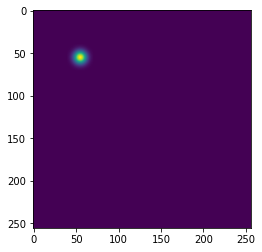

In [88]:
test_r = sparse.todense(
    draw_single_sprite(
        jnp.array([40,40]), 
        gauss_sprites[0], 
        gauss_sprites.shape[1],
        gauss_sprites.shape[2],
        (256, 256)
    ))
plt.imshow(test_r)

In [111]:
def draw_all_sprites(all_pos, all_indices, sprite_sheet, canv_dims):
  draw_bound = lambda p, sprite: draw_single_sprite(p, sprite, sprite_sheet.shape[1], sprite_sheet.shape[2], canv_dims)
  draw_all = vmap(draw_bound, in_axes=(0))
  render = draw_all(all_pos, sprite_sheet[all_indices]).sum(0)
  return sparse.todense(render) # render

In [112]:
draw_sprites_jit = jit(draw_all_sprites, static_argnums=(3,))

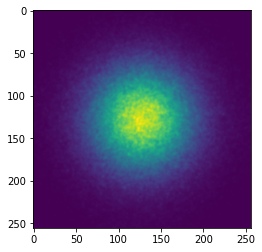

In [129]:
test_sprite_indices = jax.random.randint(key, (p_count,), minval=0, maxval=16)
test_r = draw_sprites_jit(positions * 40 + 128 - sprite_dim//2, test_sprite_indices, gauss_sprites, (256, 256) )
plt.imshow(test_r)

In [132]:
test_sprite_indices = jax.random.randint(key, (p_count,), minval=0, maxval=16)
vid_dim = 768
with media.VideoWriter("test_r.mp4", (vid_dim, vid_dim)) as wr:
  for i in tqdm(range(800)):
    test_r = draw_sprites_jit(positions * i * 0.5 + (vid_dim - sprite_dim)//2, test_sprite_indices, gauss_sprites, (vid_dim, vid_dim) )
    wr.add_image(test_r)

100%|██████████| 800/800 [00:53<00:00, 14.82it/s]


In [15]:
draw_jit(positions * 128 + 512, (1024,1024))

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
# jax.make_jaxpr(draw_points, static_argnums=(1,2))(positions, (64,64), 4)

In [18]:
import jaxlib.xla_extension as xla_ext

In [20]:
c = jax.xla_computation(draw_points, static_argnums=(1,2))(positions, (64,64), 4)

backend = jax.lib.xla_bridge.get_backend()
e = backend.compile(c)
option = xla_ext.HloPrintOptions()
option.print_metadata = False
option.include_layout_in_shapes = False
print(e.hlo_modules()[0].to_string(option))

HloModule xla_computation_draw_points.13

%region_1.83 (Arg_0.84: f32[], Arg_1.85: f32[]) -> f32[] {
  %Arg_0.84 = f32[] parameter(0)
  %Arg_1.85 = f32[] parameter(1)
  ROOT %add.86 = f32[] add(f32[] %Arg_0.84, f32[] %Arg_1.85)
}

%input_fused_computation_scatter (param_0.1: pred[2048,16], param_1.3: s16[2048,16,2]) -> f32[64,64] {
  %constant_7 = f32[] constant(0)
  %broadcast.11 = f32[64,64] broadcast(f32[] %constant_7), dimensions={}
  %param_1.3 = s16[2048,16,2] parameter(1)
  %bitcast.14 = s16[32768,2] bitcast(s16[2048,16,2] %param_1.3)
  %slice.1 = s16[32768,1] slice(s16[32768,2] %bitcast.14), slice={[0:32768], [0:1]}
  %bitcast.13 = s16[32768] bitcast(s16[32768,1] %slice.1)
  %constant_5 = s16[] constant(0)
  %broadcast.10 = s16[32768] broadcast(s16[] %constant_5), dimensions={}
  %compare.1 = pred[32768] compare(s16[32768] %bitcast.13, s16[32768] %broadcast.10), direction=LT
  %constant_3 = s16[] constant(64)
  %broadcast.9 = s16[32768] broadcast(s16[] %constant_3), dimensions=